# Time Series LSTM Algorithm

This algorithm is used to forecast FOREX prices for the USDJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

In [2]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import ta
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from UsefulFunctions import data, backtest, display

**Initiate bound between MetaTrader5 and Python**

In [4]:
# To be able to connect to MetaTrader5 you need to be already logged in with your trading account
mt5.initialize()

True

In [5]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("USDJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262,30,0
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599,30,0
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832,30,0
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761,30,0
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484,30,0


In [6]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484


## Feature engineering 
**Creating new input variables from raw data**

In [8]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,120.39,NaN
2015-01-02 09:00:00,120.43,0.000332
2015-01-02 10:00:00,120.34,-0.000747
2015-01-02 11:00:00,120.40,0.000499
2015-01-02 12:00:00,120.43,0.000249


In [9]:
# Creating new features to train the model
df_copy2 = df_copy
df_copy2["SMA 15"] = df_copy2[["close"]].rolling(15).mean().shift(1)
df_copy2["SMA 60"] = df_copy2[["close"]].rolling(60).mean().shift(1)
df_copy2["MSD 10"] = df_copy2[["close"]].rolling(10).std().shift(1)
df_copy2["MSD 30"] = df_copy2[["close"]].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df_copy2["close"], window=30, fillna=False)
df_copy2["RSI 30"] = RSI.rsi().shift(1)

WR = ta.momentum.WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=21, fillna=False)
df_copy2["WR 21"] = WR.williams_r().shift(1)

df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21
time,,,,,,,,
2015-01-06 20:00:00,118.36,-0.001013,118.910667,119.814667,0.308300,0.423147,37.046534,-72.670807
2015-01-06 21:00:00,118.62,0.002197,118.848667,119.780833,0.340361,0.415715,36.030372,-79.746835
2015-01-06 22:00:00,118.49,-0.001096,118.808000,119.750667,0.342922,0.409160,39.735411,-60.273973
2015-01-06 23:00:00,118.36,-0.001097,118.777333,119.719833,0.343455,0.420124,38.579643,-69.178082
2015-01-07 00:00:00,118.59,0.001943,118.748667,119.685833,0.283706,0.431128,37.452708,-77.142857


In [10]:
# Using the custome function "add_shifted_columns" 5 new columns are added with shifted values from close column
# Check the docstring of the "add_shifted_columns" function from the data.py file
df_copy2 = data.add_shifted_columns(df_copy2, 5, "close")
df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21,1_close_bars_ago,2_close_bars_ago,3_close_bars_ago,4_close_bars_ago,5_close_bars_ago
time,,,,,,,,,,,,,
2015-01-07 01:00:00,118.65,0.000506,118.710667,119.655167,0.240289,0.425081,40.626936,-60.714286,118.59,118.36,118.49,118.62,118.36
2015-01-07 02:00:00,118.74,0.000759,118.696000,119.624833,0.192841,0.416137,41.429091,-54.477612,118.65,118.59,118.36,118.49,118.62
2015-01-07 03:00:00,119.00,0.002190,118.690000,119.593500,0.172784,0.397710,42.631784,-47.761194,118.74,118.65,118.59,118.36,118.49
2015-01-07 04:00:00,119.06,0.000504,118.692667,119.566833,0.225657,0.383160,45.948689,-28.358209,119.00,118.74,118.65,118.59,118.36
2015-01-07 05:00:00,119.01,-0.000420,118.676000,119.539833,0.241212,0.360198,46.684583,-23.880597,119.06,119.00,118.74,118.65,118.59


## Implementing Machine Learning

In [3001]:
# Splitting the data into features and labels for the ML model using the custom function "split_data" from data.py file
X = df_copy2.iloc[:,2:]
y = df_copy2["pct_change"]

# Data si splitted in training, validation and test datasets
X_train, y_train, X_temp, y_temp = data.split_data(X, y, 70)
X_val, y_val, X_test, y_test = data.split_data(X_temp, y_temp, 50)

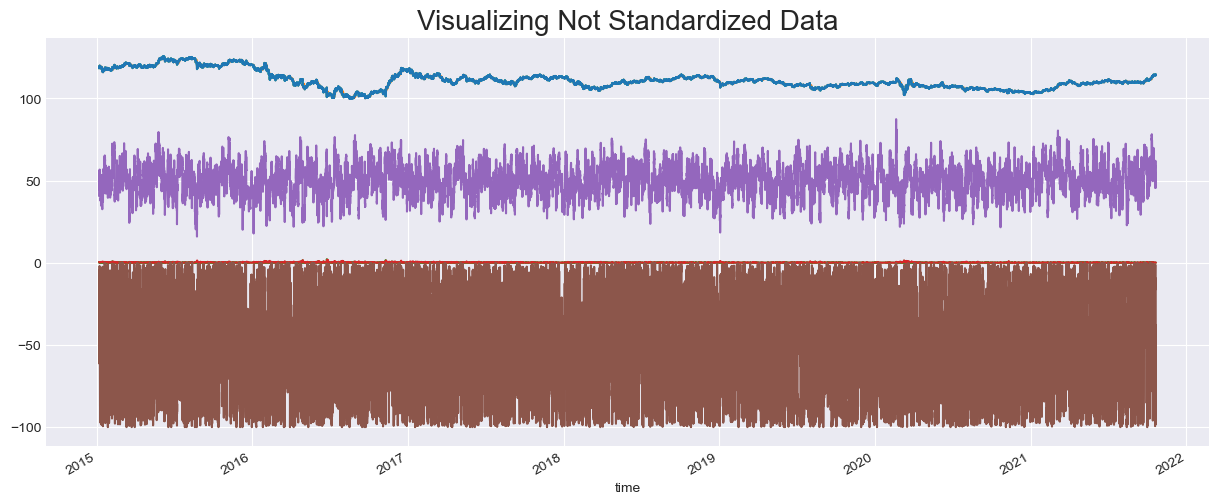

In [3003]:
# Plotting features before standardization to visualize their unequal scales
X_train.plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Not Standardized Data", fontsize=20)
plt.show()

### Applying StandardScaler to Normalize Features

In [3005]:
from sklearn.preprocessing import MinMaxScaler

In [3006]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

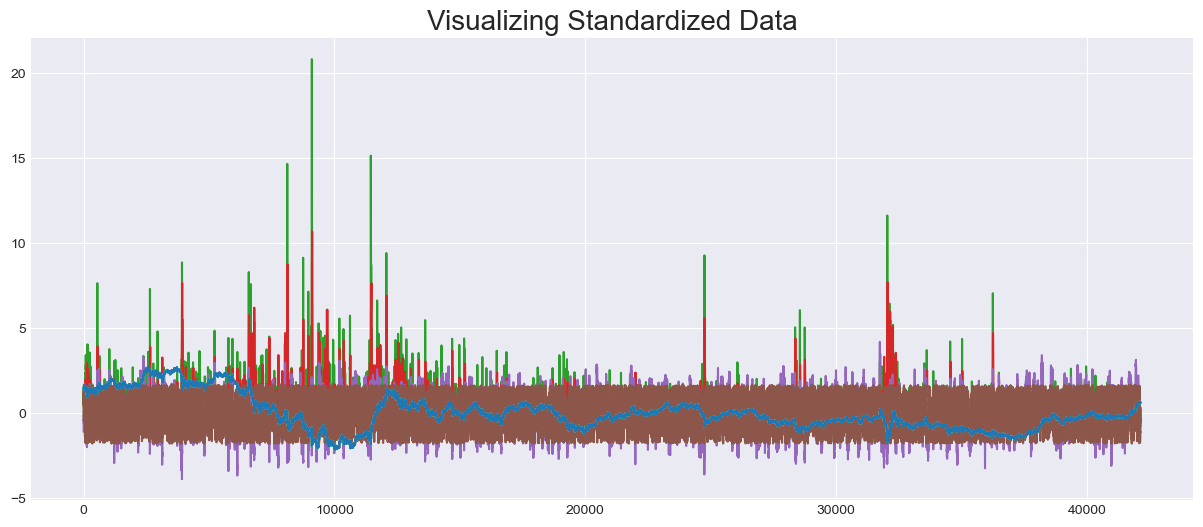

In [3007]:
pd.DataFrame(X_train_scaled).plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Standardized Data", fontsize=20)
plt.show()

**Transforming 2D data into 3D datasets**

This is the proper data shape received by the LSTM algorithm

In [3009]:
# Creating a function to transfor the 2D data into 3D data
def create_3d_data(X_data, y_data, lag):
    X_data_3d = []
    y_data_3d = []

    for i in range(lag, len(X_data)):
        X_data_3d.append(X_data[i-lag:i])
        y_data_3d.append(y_data[i])

    X_data_3d = np.array(X_data_3d)
    y_data_3d = np.array(y_data_3d)

    return X_data_3d, y_data_3d

**Transforming labels into classes**

- If percent change is lower than 0 is set to 0
- If equal 0 is set to 1
- If it's above 0 is set to 2

(those are price movement directions)

In [3180]:
X_train_3d, y_train_3d = create_3d_data(X_train_scaled, np.sign(y_train)+1, 5)
X_val_3d, y_val_3d = create_3d_data(X_val_scaled, np.sign(y_val)+1, 5)
X_test_3d, y_test_3d = create_3d_data(X_test_scaled, np.sign(y_test)+1, 5)


**Showing the 3 type of classes**

In [3300]:
pd.DataFrame(y_train_3d).value_counts()

0  
2.0    21088
0.0    20331
1.0      714
Name: count, dtype: int64

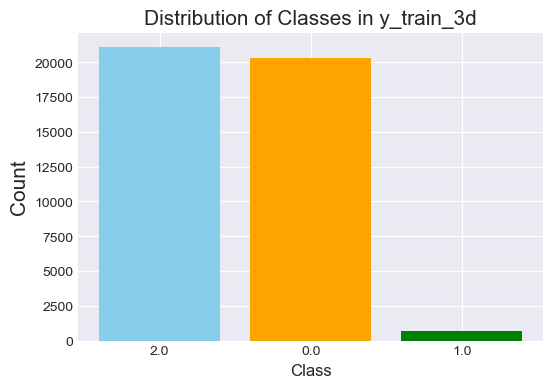

In [3302]:
value_counts = pd.DataFrame(y_train_3d).value_counts()

# Convert the result to a DataFrame for plotting
value_counts_df = value_counts.reset_index(name="count")

# Rename the columns for clarity
value_counts_df.columns = ["Class", "Count"]

# Plotting the bar chart
plt.figure(figsize=(6,4))
plt.bar(value_counts_df["Class"].astype(str), value_counts_df["Count"], color=["skyblue", "orange", "green"])

# Adding title and labels
plt.title("Distribution of Classes in y_train_3d", fontsize=15)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=15)
plt.show()


In [3052]:
# Showing the new shape of the X_train dataset
print(f"Old shape of X_train dataset    {X_train_scaled.shape}")
print(f"New shape of X_train dataset    {X_train_3d.shape}")

Old shape of X_train dataset    (42138, 11)
New shape of X_train dataset    (42133, 5, 11)


**Showing the first 3D row of the new X 3D dataset**

In [3055]:
pd.DataFrame(X_train_3d[0])

,0,1,2,3,4,5,6,7,8,9,10
0,1.455350,1.635839,1.176432,1.358607,-1.094330,-0.443140,1.431949,1.388339,1.412917,1.437492,1.388203
1,1.452571,1.630084,0.706174,1.301059,-1.003755,-0.228916,1.443314,1.431904,1.388294,1.412870,1.437447
2,1.451434,1.624138,0.507389,1.182490,-0.867952,0.001786,1.460362,1.443269,1.431858,1.388247,1.412825
3,1.451939,1.619079,1.031412,1.088869,-0.493423,0.668260,1.509610,1.460316,1.443222,1.431810,1.388203
4,1.448781,1.613956,1.185580,0.941117,-0.410329,0.822061,1.520975,1.509563,1.460269,1.443174,1.431765


In [3057]:
# This are the new labels represented as classes
pd.DataFrame(y_test_3d).tail()

,0
9020,2.0
9021,2.0
9022,2.0
9023,2.0
9024,0.0


In [3308]:
# Showing original values
pd.DataFrame(y_test).tail()

,pct_change
time,
2024-09-13 19:00:00,0.001038
2024-09-13 20:00:00,0.000689
2024-09-13 21:00:00,0.000142
2024-09-13 22:00:00,0.000014
2024-09-13 23:00:00,-0.000341


**Prefetching data to make the algorithms run faster**

In [3062]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import os

In [3064]:
# Convert both X and y datasets into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_3d, y_train_3d))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_3d, y_val_3d))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_3d, y_test_3d))

# Batch and prefetch
batch_size = 256  
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [6297]:
# Creating a function to implement a ModelChechpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
    # Ensure the directory exists
    #os.makedirs(save_path, exist_ok=True)
    
    return ModelCheckpoint(
        filepath=os.path.join(save_path, f"{model_name}.keras"),
        monitor="val_loss",
        verbose=0,
        save_best_only=True
    )

**Creating a function to easily run several models and try different combination of hyperparameters**

In [5820]:
def run_lstm(train_sets, 
             val_sets, 
             model_name, 
             neurons=64, 
             hidden_layers=2, 
             p_epochs=30,
             dropout=0.20,
             lr=0.001, 
             early_stopping_ptn=15,
             reduce_plateau_ptn=5,
             rp_lr=0.05,
             path="model_experiments",
             p_batch_size=512):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break
    
   
    model = Sequential(name=model_name)

    # Input layer
    model.add(LSTM(neurons, input_shape=(features_input_shape), activation="tanh", return_sequences=True, name="input_layer_0"))

    # hidden layers
    for i in range(0, hidden_layers):
        model.add(LSTM(int(neurons/2), activation="tanh", return_sequences=True, name=f"hidden_layer_{i}"))
        model.add(Dropout(dropout, name=f"dropout_layer_{i}"))

    # Last hidden layer
    model.add(LSTM(int(neurons/4), activation="tanh", return_sequences=False, name=f"last_hidden_layer"))
    model.add(Dropout(dropout, name="last_dropout_layer_"))
    
    # Output layer
    model.add(Dense(3, activation="softmax", name="output_layer"))
    
    checkpoint_callback = create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2)

    # Compiling the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=lr), metrics=["accuracy"])

    # Training the model
    history = model.fit(train_sets,
                       validation_data=val_sets, 
                       batch_size=p_batch_size, 
                       epochs=p_epochs,
                       verbose=0,
                       callbacks=[checkpoint_callback, early_stopping, reduce_plateau]
                      )
    return history

**Training the Model_1**

In [5871]:
history_model_1 = run_lstm(train_sets=train_dataset,
                           val_sets=val_dataset,
                           model_name="model_1",
                           neurons=7,
                           hidden_layers=1,
                           p_epochs=7,
                           lr=0.001,
                           early_stopping_ptn=5,
                           reduce_plateau_ptn=3,
                           path="model_experiments_1"
                          )


Epoch 1: val_loss improved from inf to 0.97577, saving model to model_experiments_1\model_1.keras

Epoch 2: val_loss improved from 0.97577 to 0.90323, saving model to model_experiments_1\model_1.keras

Epoch 3: val_loss improved from 0.90323 to 0.85071, saving model to model_experiments_1\model_1.keras

Epoch 4: val_loss improved from 0.85071 to 0.81183, saving model to model_experiments_1\model_1.keras

Epoch 5: val_loss improved from 0.81183 to 0.78034, saving model to model_experiments_1\model_1.keras

Epoch 6: val_loss improved from 0.78034 to 0.75883, saving model to model_experiments_1\model_1.keras

Epoch 7: val_loss improved from 0.75883 to 0.74884, saving model to model_experiments_1\model_1.keras


In [5872]:
from tensorflow.keras.models import load_model

**Loading the Model and Showing its Architecture**

In [5874]:
model_1 = load_model(f"model_experiments_1/{"model_1"}.keras")
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (LSTM)            │ (None, 5, 7)           │           532 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_0 (LSTM)           │ (None, 5, 3)           │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_0 (Dropout)       │ (None, 5, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_hidden_layer (LSTM)        │ (None, 1)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_dropout_layer_ (Dropout)   │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,072 (8.10 KB)

 Trainable params: 690 (2.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,382 (5.40 KB)

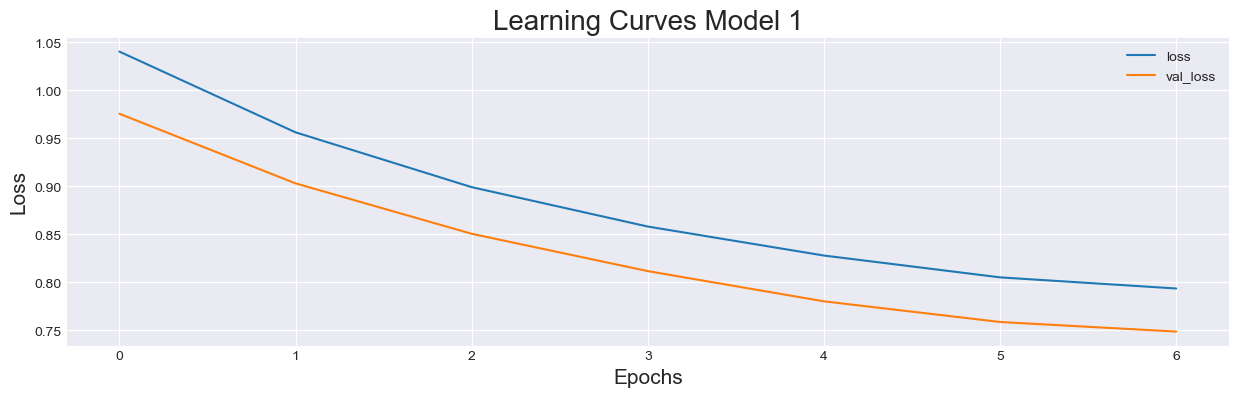

In [5875]:
pd.DataFrame(history_model_1.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model 1", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

**Note: I've run and tuned the hypeparameters several times and still LSTM algorithm not performing very well**

In [5877]:
# Evaluating the model
model_1.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4804 - loss: 0.7500


[0.7509186863899231, 0.4805540144443512]

**Making predictions**

In [5879]:
model_1_pred = model_1.predict(X_test_3d)

283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


In [5880]:
# Showing the shape of the predictions outcome
model_1_pred.shape

(9025, 3)

In [5881]:
# Showeing the predictions probabilites
pd.DataFrame(model_1_pred)

,0,1,2
0,0.482649,0.042414,0.474938
1,0.482927,0.042625,0.474447
2,0.483066,0.042732,0.474202
3,0.483179,0.042818,0.474003
4,0.483462,0.043036,0.473502
...,...,...,...
9020,0.484942,0.044203,0.470856
9021,0.484971,0.044226,0.470803
9022,0.484942,0.044203,0.470855
9023,0.484870,0.044145,0.470984


**Transforming predictions (probabilities) into positions**

In [5883]:
# Getting the predicted class index (e.g., 0, 1, or 2)
predicted_class_indices = np.argmax(model_1_pred, axis=1)
# Corrected mapping from model output indices to original labels
index_to_label = {0: -1, 1: 0, 2: 1}

# Predicted_class_indices is the output of np.argmax on model predictions
positions_model_1 = [index_to_label[idx] for idx in predicted_class_indices]
pd.DataFrame(positions_model_1).value_counts()

0 
-1    8943
 1      82
Name: count, dtype: int64

In [5884]:
predicted_labels_df = pd.DataFrame(positions_model_1, columns=["prediction"])
predicted_labels_df.head()

,prediction
0,-1
1,-1
2,-1
3,-1
4,-1


In [5885]:
# The original targets dataset has 9030 rows, since the lag used to make 3D data set is 5, it's required 
# to removed those firts 5 rows to match the amout of the predictions output for further analysis
pd.DataFrame(y_test)

,pct_change
time,
2023-04-03 19:00:00,0.000710
2023-04-03 20:00:00,0.000068
2023-04-03 21:00:00,-0.000785
2023-04-03 22:00:00,0.000672
2023-04-03 23:00:00,-0.000332
...,...
2024-09-13 19:00:00,0.001038
2024-09-13 20:00:00,0.000689
2024-09-13 21:00:00,0.000142


In [5886]:
# DataFrame comparing actual target values with predicted positions.
# The first 5 rows of y_test are excluded to match the length of predicted_labels_df, ensuring proper alignment for comparison.

# Checkout the docstring from for the "compute_stratety_returns" fucntions from backtest.py
returns_model_1 = backtest.compute_strategy_returns(y_test[5:], positions_model_1)
returns_model_1.head()

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2023-04-04 00:00:00,0.000053,-1,1.0,-1,-0.000053
2023-04-04 01:00:00,-0.000446,-1,-1.0,-1,0.000446
2023-04-04 02:00:00,-0.000227,-1,-1.0,-1,0.000227
2023-04-04 03:00:00,0.001769,-1,1.0,-1,-0.001769
2023-04-04 04:00:00,0.001728,-1,1.0,-1,-0.001728


**Plotting the Cumulative Returns from Model 1**

Profits : -8.11%


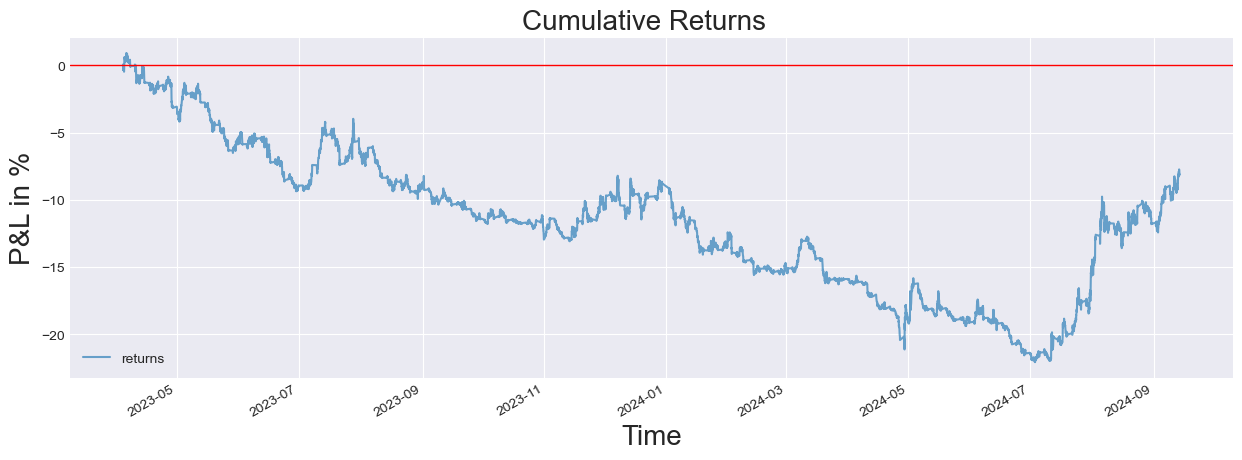

In [5888]:
# Checkout the docstring from for the "plot_test_returns" fucntions from display.py
display.plot_test_returns(returns_model_1["returns"])

**Forecast Accuracy Analysis for Model 1**

Predicted vs. Real Positions

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
0    4688
1    4337
Name: count, dtype: int64

Model has an accuracy of: 48.06%


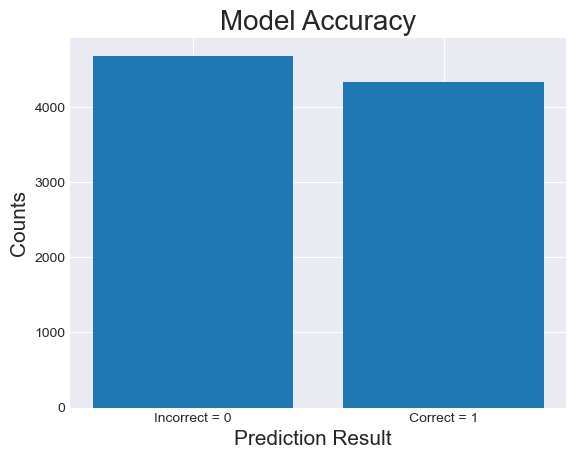

,real_position,pred_position,accuracy
time,,,
2023-04-04 00:00:00,1.0,-1,0
2023-04-04 01:00:00,-1.0,-1,1
2023-04-04 02:00:00,-1.0,-1,1
2023-04-04 03:00:00,1.0,-1,0
2023-04-04 04:00:00,1.0,-1,0


In [5890]:
# Checkout the docstring from for the "compute_model_accuracy" fucntions from backtest.py
backtest.compute_model_accuracy(returns_model_1["real_position"], returns_model_1["pred_position"])

**Confusion Matrix**

In [5892]:
from sklearn.metrics import confusion_matrix

**Confusion Matrix**

It shows us the performance of the model as follows:
- True positives
- True negatives
- False positives
- False negatives

In [6141]:
#The model has predicted almost exclusively downward price movements, indicating poor performance and a lack of balanced predictions.
confusion_matrix(returns_model_1["real_position"], returns_model_1["pred_position"])

array([[4296,    0,   41],
       [  45,    0,    0],
       [4602,    0,   41]], dtype=int64)

## New LSTM Model

**After some research the new model is enhanced for a more sophisticated: Regularization, Bidirectional Layers, and Batch Normalization are added**

- **Kernerl Regularizer:** This helps to prevent overfitting by keeping the weights from becoming too large.
- **Bidirectional layer:** With this the input data is processed both directions, from the beginning to the end and from the end to the beginning.
- **Batch normalization:** It helps stabilize the learning process by normalizing the inputs to each next layer in the network.

In [4088]:
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2

In [6299]:
def run_lstm(train_sets, 
             val_sets, 
             model_name, 
             neurons=64, 
             hidden_layers=2, 
             p_epochs=30,
             dropout=0.20,
             lr=0.001, 
             early_stopping_ptn=15,
             reduce_plateau_ptn=5,
             rp_lr=0.5,
             path="model_experiments",
             p_batch_size=512,
             kr_l2=0.1):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break
       
    model = Sequential(name=model_name)

    # Input layer
    model.add(Bidirectional(LSTM(neurons, activation="tanh", return_sequences=True, kernel_regularizer=l2(kr_l2)), 
                            input_shape=features_input_shape, name="input_layer_0"))
    model.add(BatchNormalization())

    # hidden layers
    for i in range(hidden_layers):
        model.add(Bidirectional(LSTM(int(neurons/2), activation="tanh", return_sequences=True, kernel_regularizer=l2(kr_l2)), name=f"hidden_layer_{i}"))
        model.add(BatchNormalization())
        model.add(Dropout(dropout, name=f"dropout_layer_{i}"))    

    # Last hidden layer
    model.add(Bidirectional(LSTM(int(neurons/4), activation="tanh", return_sequences=False, kernel_regularizer=l2(kr_l2)), name="last_hidden_layer"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout, name="Last_dropout_layer"))

    # Output layer
    model.add(Dense(3, activation="softmax", name="output_layer"))
    
    checkpoint_callback = create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=0)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2, min_lr=1e-4)

    # Compiling the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=lr), metrics=["accuracy"])

    # Training the model
    history = model.fit(train_sets,
                        validation_data=val_sets,
                        batch_size=p_batch_size,
                        epochs=p_epochs,
                        verbose=0,
                        callbacks=[checkpoint_callback, early_stopping, reduce_plateau]
                        )
    return history

**Training the Model_2**

In [6271]:
history_model_2 = run_lstm(train_sets=train_dataset,
                           val_sets=val_dataset,
                           model_name="model_2",
                           neurons=5,
                           p_epochs=5,
                           hidden_layers=1,
                           lr=0.0005,
                           early_stopping_ptn=5,
                           reduce_plateau_ptn=3,
                           path="model_experiments_2",
                           kr_l2=0.2
                          )


Epoch 1: val_loss improved from inf to 7.66065, saving model to model_experiments_2\model_2.keras

Epoch 2: val_loss improved from 7.66065 to 5.05093, saving model to model_experiments_2\model_2.keras

Epoch 3: val_loss improved from 5.05093 to 3.43146, saving model to model_experiments_2\model_2.keras

Epoch 4: val_loss improved from 3.43146 to 2.40832, saving model to model_experiments_2\model_2.keras

Epoch 5: val_loss improved from 2.40832 to 1.72873, saving model to model_experiments_2\model_2.keras


**Loading the Model_2**

In [6273]:
model_2 = load_model(f"model_experiments_2/{"model_2"}.keras")
model_2.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Bidirectional)   │ (None, 5, 10)          │           680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_388         │ (None, 5, 10)          │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_0 (Bidirectional)  │ (None, 5, 4)           │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_389         │ (None, 5, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_0 (Dropout)       │ (None, 5, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_hidden_layer               │ (None, 2)              │            48 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_390         │ (None, 2)              │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Last_dropout_layer (Dropout)    │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,965 (11.59 KB)

 Trainable params: 977 (3.82 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 1,956 (7.64 KB)

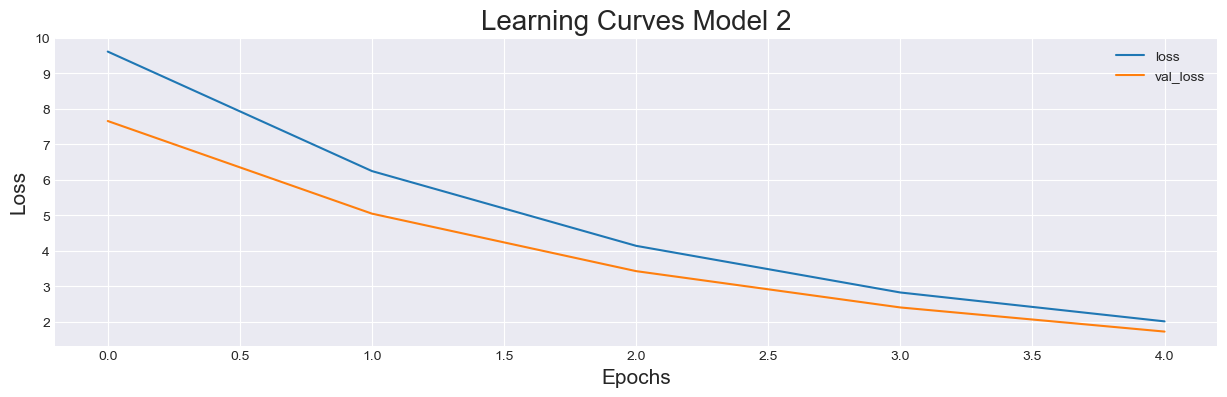

In [6274]:
pd.DataFrame(history_model_2.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model 2", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [6275]:
# Evaluating the model
model_2.evaluate(test_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5087 - loss: 1.7502


[1.7579046487808228, 0.5021606683731079]

**Making Predictions from Model_2**

In [6277]:
model_2_pred = model_2.predict(X_test_3d)

283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [6278]:
# Showeing the predictions probabilites
pd.DataFrame(model_2_pred).head()

,0,1,2
0,0.406815,0.179102,0.414083
1,0.409020,0.170404,0.420576
2,0.410927,0.162301,0.426772
3,0.413086,0.152355,0.434559
4,0.415033,0.142337,0.442630


**Transforming predictions (probabilities) into positions fro Model_2**

In [6286]:
predicted_class_indices = np.argmax(model_2_pred, axis=1)
index_to_label = {0: -1, 1: 0, 2: 1}
positions_model_2 = [index_to_label[idx] for idx in predicted_class_indices]
positions_model_2
pd.DataFrame(positions_model_2).value_counts()

0 
 1    6572
-1    2453
Name: count, dtype: int64

**Computing Returns for Model_2**

In [6289]:
returns_model_2 = backtest.compute_strategy_returns(y_test[5:], positions_model_2)
returns_model_2.head()

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2023-04-04 00:00:00,0.000053,1,1.0,1,0.000053
2023-04-04 01:00:00,-0.000446,1,-1.0,1,-0.000446
2023-04-04 02:00:00,-0.000227,1,-1.0,1,-0.000227
2023-04-04 03:00:00,0.001769,1,1.0,1,0.001769
2023-04-04 04:00:00,0.001728,1,1.0,1,0.001728


**Plotting the Cumulative Returns from Model 2**

Profits : 9.36%


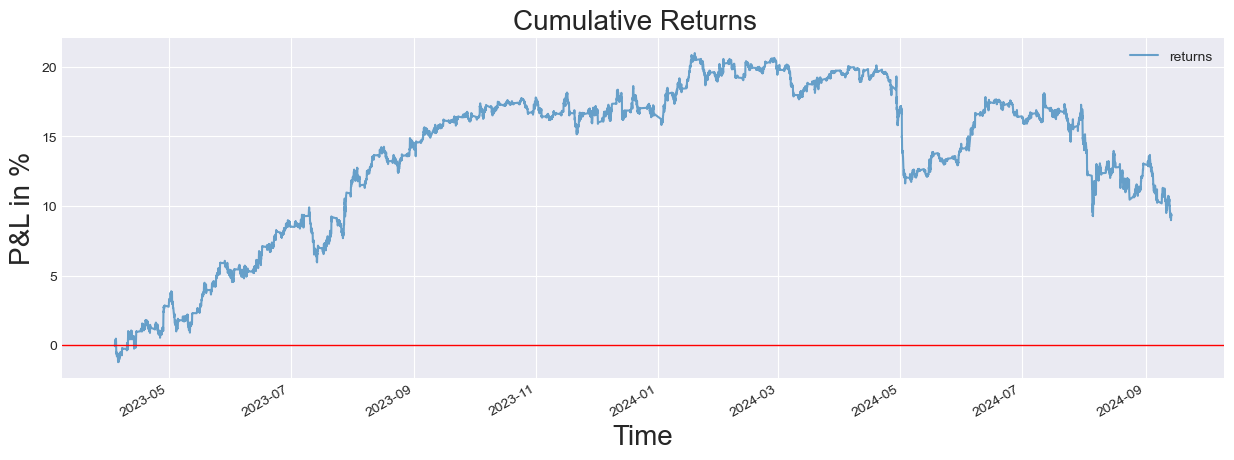

In [6292]:
display.plot_test_returns(returns_model_2["returns"])

**Confusion Matrix**

It shows us the performance of the model as follows:

In [6295]:
# We can see the model has only predicted up direction for the price movements. This means the model is not performing well
confusion_matrix(returns_model_2["real_position"], returns_model_2["pred_position"])

array([[1162,    0, 3175],
       [  18,    0,   27],
       [1273,    0, 3370]], dtype=int64)

In [ ]:
## Running 100 Versions 